# Example of discrete hedging experiment for a European Call option under the BS model
Consider a market model with two assets, a Bank account and a Stock with $P$-dynamics

$$
dB(t) = rB(t) dt, \hspace{10mm} B(0) = 1 \\
dS(t) = \mu S(t) dt + \sigma S(t) dW(t), \hspace{10mm} S(0) = s > 0
$$

Consider the European call options that at time $T$ pays $X = (S(T) - K)^+$ where $K > 0$ is the strike price.

Chope the time interval between now (time 0) and expiry of the call-option (time $T$) into $N$ pieces; denote the discretization points $t_i$.  

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    print('Adding module')
    sys.path.append(module_path)

Adding module


In [2]:
import numpy as np

import jax.numpy as jnp
import matplotlib.pyplot as plt

from jaxfin.models.gbm import UnivGeometricBrownianMotion
from jaxfin.price_engine.black_scholes import european_price, delta_european

In [3]:
seed = 42

$$
S(0) = 100 \\
\sigma = 0.2 \\
\mu = 0.00 \\
$$

Let set $N = 252$, which means that we are rebalancing our portfolio daily.

In [4]:
s0 = 100
sigma = 0.2
mean = 0.00

params = {
    's0' : s0,
    'dtype' : jnp.float32,
    'mean' : mean,
    'sigma': sigma
}
gmb = UnivGeometricBrownianMotion(**params)

In [5]:
maturity = 1.0
N = 252
dt = maturity / N
n_sim = 1000

stock_paths = gmb.simulate_paths(seed, maturity, N, n_sim)

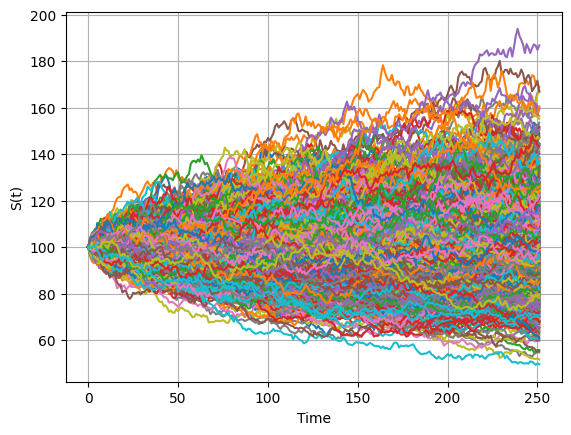

In [6]:
plt.plot(stock_paths)
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [7]:
K = 110
discount_rate = 0.0
dividends = 0.0

In [8]:
deltas = [delta_european(stock_paths[i], K, maturity - i * dt, sigma, discount_rate, dtype=jnp.float32) for i in range(0, N)]
cs = [european_price(stock_paths[i], K, maturity - i * dt, sigma, discount_rate, dtype=jnp.float32) for i in range(0, N)]
b = [cs[0] - deltas[0] * stock_paths[0]]
vs = [cs[0]]

for i in range(1, N):
    vs.append(deltas[i - 1] * stock_paths[i] + b[i - 1])
    b.append(vs[i] - deltas[i] * stock_paths[i])
    
hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

In [21]:
print(f'The mean hedge error is: {jnp.mean(hedge_error[-1])}')
print(f'The (normalized) standard deviation is: {jnp.std(hedge_error[-1]) / jnp.asarray(cs)[0, 0]}')

The mean hedge error is: 0.008731728419661522
The (normalized) standard deviation is: 0.10425914824008942


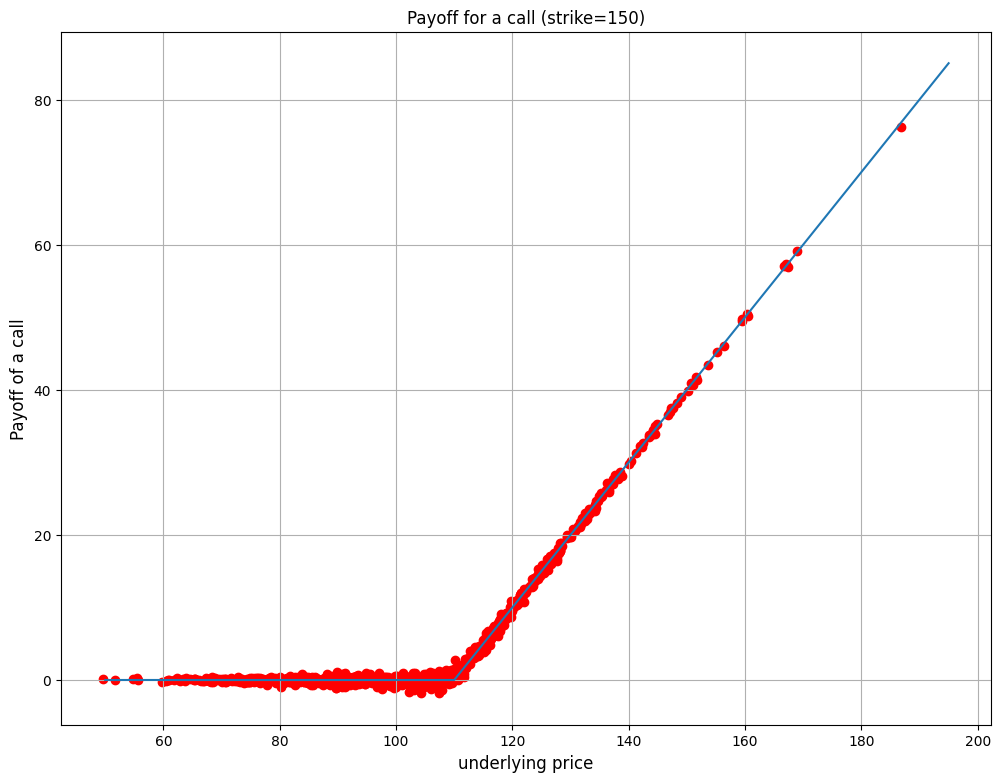

In [10]:
font = {'color':  'black',
        'weight': 'normal',
        'size': 12
       }

s = jnp.arange(50,200,5)
payoff= jnp.maximum(s - K, 0)
plt.figure(figsize=(12,9))
plt.plot(s,payoff)
plt.scatter(stock_paths[-1, :], jnp.asarray(vs)[-1, :], c='red')
plt.title("Payoff for a call (strike=150)", fontdict=font)
plt.xlabel("underlying price", fontdict=font)
plt.ylabel("Payoff of a call", fontdict=font)
plt.grid(True)
plt.show()